# Notebook 14: Social Networks
***

In this notebook we'll work through a few of the key steps in characterizing structure within a social network. Namely, we can unpack some of the mechanics surrounding estimating the community membership strength matrix $F$, and the steps necessary in order to estimate the elements of $F$ using gradient ascent.

We'll need numpy for this notebook, so let's load it.

In [1]:
import numpy as np
import networkx as nx

<br>

### Exercise 1: Computing connection probabilities

Suppose there are 4 college students who are enrolled in different courses. As any of you, who are all in the same class - *this most glorious of classes* - are aware, being enrolled in similar/same classes has an effect on whether or not students are connected to one another. The students' membership strengths in those class communities are given below.

$$\begin{array}{c|cccc}
   & \text{Calculus IV} & \text{Intro to Pseudoscience} & \text{Remedial Recess} & \text{Advanced Living} \\
   \hline
 \text{Jake}  & 0   & 0.2 & 0.6 & 0.8 \\
 \text{Bri}   & 0.1 & 0.3 & 0.4 & 0.9 \\
 \text{David} & 1   & 0.4 & 0.5 & 0.4 \\
 \text{Alaina}& 0.8 & 0.1 & 0.7 & 0.5 \\
 \end{array}$$
 
Write down and simplify as much as possible expressions for the following connection probabilities. Then, compute them in Python.

1. $P(Jake, Bri)$
1. $P(Jake, David)$
1. $P(David, Alaina)$

In [2]:
# SOLUTION:

F = np.array([[0  ,0.2,0.6,0.8],
              [0.1,0.3,0.4,0.9],
              [1.0,0.4,0.5,0.4],
              [0.8,0.1,0.7,0.5]])

print("P(Jake, Bri) = {:0.4f}".format(1 - np.exp(-np.sum(F[0,:]*F[1,:]))))
print("P(Jake, David) = {:0.4f}".format(1 - np.exp(-np.sum(F[0,:]*F[2,:]))))
print("P(David, Alaina) = {:0.4f}".format(1 - np.exp(-np.sum(F[2,:]*F[3,:]))))

P(Jake, Bri) = 0.6394
P(Jake, David) = 0.5034
P(David, Alaina) = 0.7509


<br>

### Exercise 2: Log-likelihood is the queen of functions

In reality, we would mine a network graph, say, from Facebook, LinkedIn, or some other networking site. Then, we would use that if estimate the elements of the community membership strength matrix, $F$, by choosing the elements of $F$ to maximize the log-likelihood:
$$l(F) = \sum_{(u,v)\in E} \log{(1 - \exp{(-\vec{F}_u\cdot \vec{F}_v)})} - \sum_{(u,v)\notin E} \vec{F}_u\cdot \vec{F}_v$$
where $E$ is the edge set for the graph (which we assume to be undirected).

Suppose our network graph actually looks like this:

<img width=130px src="http://www.cs.colorado.edu/~anwo7157/home/resources/socialnetwork1.png">

What then is the log-likelihood for the $F$ community strength matrix given in Exercise 1?

In [3]:
# Assume same order as the rows of F: J, B, D, A
J = 0; B = 1; D = 2; A = 3

# Edge set
E = [[J, B], [J, D], [J, A], [D, A]]

# All edges
EU = [[J, B], [J, D], [J, A], [B, D], [B, A], [D, A]]

In [4]:
# SOLUTION:

llhood = np.sum([np.log(1-np.exp(-np.sum(F[edge[0],:]*F[edge[1],:]))) for edge in E]) - \
         np.sum([np.sum(F[edge[0],:]*F[edge[1],:]) if edge not in E else 0 for edge in EU])
print(llhood)

-3.605132384756333


Can you play around with any of the elements of $F$ in order to increase the log-likelihood value? What does an increase in the log-likelihood mean, in terms of how the community membership strength matrix represents the given graph? Can you use some of the structure of the graph to justify the change you make in the $F$ matrix?

**Solution:**

Sure! In the graph, Jake and Alaina are connected, but Alaina has a high membership strength in Calculus IV, whereas Jake has 0 membership strength in that class community. So, if we increase Jake's membership strength there, the log-likelihood should increase, since the membership strength matrix better represents what is shown in the graph connections.

So, we just increase Jake's membership strength in Calculus IV from 0 to 0.5 and voila!

In [5]:
# SOLUTION:

F = np.array([[0.5,0.2,0.6,0.8],
              [0.1,0.3,0.4,0.9],
              [1.0,0.4,0.5,0.4],
              [0.8,0.1,0.7,0.5]])
llhood = np.sum([np.log(1-np.exp(-np.sum(F[edge[0],:]*F[edge[1],:]))) for edge in E]) - \
         np.sum([np.sum(F[edge[0],:]*F[edge[1],:]) if edge not in E else 0 for edge in EU])
print(llhood)

-3.026539933429717


<br>

### Exercise 3: Gradient ascent

In order to choose components of $F$ to maximize the log-likelihood function, we use **gradient ascent**. A crucial part of gradient ascent is to be able to compute $\nabla l(F_u)$ the gradient of $l(F)$ with respect to the row of $F$ corresponding to node $u$. So, taking David as an example, the gradient of the log-likelihood with respect to the components in David's row is:

$$\nabla l(F_D) = \bigg\langle \sum_{v \in N(D)} F_{v,A} \dfrac{\exp{(-\vec{F}_D \cdot \vec{F}_v)}}{1-\exp{(-\vec{F}_D \cdot \vec{F}_v)}} - \sum_{v \notin N(D)} F_{v,A}, \sum_{v \in N(D)} F_{v,B} \dfrac{\exp{(-\vec{F}_D \cdot \vec{F}_v)}}{1-\exp{(-\vec{F}_D \cdot \vec{F}_v)}} - \sum_{v \notin N(D)} F_{v,B}, \ldots \bigg\rangle,$$

where $A$, $B$, ... represent each of the communities (classes) and $N(D)$ is the set of neighbor nodes of David (Alaina and Jake).

In [6]:
neighbors = [A,J]
not_neighbors = [B]

Taking our original $F$ matrix from the first exercise, let's compute the gradient with respect to David's row, and update his row using step size (learning rate) $\eta = 0.1$. We'll compute the first component (with respect to David and Calculus IV) together:

In [7]:
F = np.array([[0  ,0.2,0.6,0.8],
              [0.1,0.3,0.4,0.9],
              [1.0,0.4,0.5,0.4],
              [0.8,0.1,0.7,0.5]])

first_sum = np.sum([F[v,0]*np.exp(-np.sum(F[D,:]*F[v,:]))/(1-np.exp(-np.sum(F[D,:]*F[v,:]))) for v in neighbors])
second_sum = np.sum([F[v,0] for v in not_neighbors])
the_whole_enchilada = first_sum - second_sum
print(the_whole_enchilada)

0.16535316381837276


Compute the other components of $\nabla l(F_D)$, the ones with respect to the other class communities. It might be a good idea to store them all in a well-named array, instead of silly variable names that are easy to forget but funny to say. Note that we have the Calculus IV component of the gradient from above, so you can check your work using that.

In [8]:
# SOLUTION:

# initialize some useful things
grad_llhood = np.zeros(4)  # one log-likelihood gradient value for each community

for comm in range(4):
    first_sum = np.sum([F[v,comm]*np.exp(-np.sum(F[D,:]*F[v,:]))/(1-np.exp(-np.sum(F[D,:]*F[v,:]))) for v in neighbors])
    second_sum = np.sum([F[v,comm] for v in not_neighbors])
    grad_llhood[comm] = first_sum - second_sum

print(grad_llhood)

[ 0.16535316 -0.06954408  0.42404434  0.05499282]


We can now update the David row of $F$ as $F_D^{new} = F_D^{old} + \eta\cdot \nabla l(F_D)$:

In [9]:
eta = 0.1
F_new = F.copy()
F_new[D,:] += eta*grad_llhood
print("F_old:", np.round(F,4))
print("F_new:", np.round(F_new,4))

F_old: [[0.  0.2 0.6 0.8]
 [0.1 0.3 0.4 0.9]
 [1.  0.4 0.5 0.4]
 [0.8 0.1 0.7 0.5]]
F_new: [[0.     0.2    0.6    0.8   ]
 [0.1    0.3    0.4    0.9   ]
 [1.0165 0.393  0.5424 0.4055]
 [0.8    0.1    0.7    0.5   ]]


Now, update the remaining rows of $F$. Some notes:
* If any elements of $F$ are updated to yield membership strengths < 0, those should be reset to 0. 
* You will need to make sure you change the `neighbors` and `not_neighbors` sets with each new row of $F$ you are updating.

With that, you will have performed one full iteration of gradient ascent!

In [10]:
# SOLUTION:
F_new = F.copy()

nodes = [J,B,D,A]
neighbors = [[B,D,A], [J], [A,J], [D,J]]

print("F_old:", np.round(F_new,4))

for u in [J,B,A]:
    not_neighbors = list(set(nodes)-set(neighbors[u]))
    for comm in range(4):
        first_sum = np.sum([F[v,comm]*np.exp(-np.sum(F[u,:]*F[v,:]))/(1-np.exp(-np.sum(F[u,:]*F[v,:]))) for v in neighbors[u]])
        second_sum = np.sum([F[v,comm] for v in not_neighbors])
        grad_llhood[comm] = first_sum - second_sum
        #print (u, comm, grad_llhood[comm])

    F_new[u,:] += eta*grad_llhood
    if any(F_new[u,:] < 0):
        F_new[u,:] = [max([F_new[B,k], 0]) for k in range(4)]

print("F_new:", np.round(F_new,4))

F_old: [[0.  0.2 0.6 0.8]
 [0.1 0.3 0.4 0.9]
 [1.  0.4 0.5 0.4]
 [0.8 0.1 0.7 0.5]]
F_new: [[0.1651 0.244  0.6651 0.8482]
 [0.     0.2313 0.2738 0.7651]
 [1.     0.4    0.5    0.4   ]
 [0.7432 0.0885 0.6522 0.434 ]]


Note that our update didn't follow the order of the nodes in the matrix. That's fine, it turns out it's like a watered down version of *stochastic* gradient ascent. If the order in which we update the $F$ matrix makes a big difference, then we have bigger problems to worry about.

So what happens if we take 100 steps?

In [11]:
# SOLUTION:
F_new = F.copy()

nodes = [J,B,D,A]
neighbors = [[B,D,A], [J], [A,J], [D,J]]

print("F_old:", np.round(F_new,4))

for steps in range(100):
    for u in [D,J,B,A]:
        not_neighbors = list(set(nodes)-set(neighbors[u]))
        for comm in range(4):
            first_sum = np.sum([F[v,comm]*(np.exp(-np.sum(F[u,:]*F[v,:]))/(1-np.exp(-np.sum(F[u,:]*F[v,:])))) for v in neighbors[u]])
            second_sum = np.sum([F[v,comm] for v in not_neighbors])
            grad_llhood[comm] = first_sum - second_sum
            #print (u, comm, grad_llhood[comm])

        F_new[u,:] += eta*grad_llhood
        if any(F_new[u,:] < 0):
            F_new[u,:] = [max([F_new[B,k], 0]) for k in range(4)]
    print("F_new:", np.round(F_new,4))
# print("F_new:", np.round(F_new,4))

F_old: [[0.  0.2 0.6 0.8]
 [0.1 0.3 0.4 0.9]
 [1.  0.4 0.5 0.4]
 [0.8 0.1 0.7 0.5]]
F_new: [[0.1651 0.244  0.6651 0.8482]
 [0.     0.2313 0.2738 0.7651]
 [0.9165 0.353  0.4924 0.3655]
 [0.7432 0.0885 0.6522 0.434 ]]
F_new: [[0.3301 0.2879 0.7301 0.8964]
 [0.     0.1626 0.1477 0.6302]
 [0.8331 0.3061 0.4848 0.331 ]
 [0.6863 0.0769 0.6043 0.3681]]
F_new: [[0.4952 0.3319 0.7952 0.9446]
 [0.     0.0938 0.0215 0.4953]
 [0.7496 0.2591 0.4772 0.2965]
 [0.6295 0.0654 0.5565 0.3021]]
F_new: [[0.6602 0.3759 0.8602 0.9928]
 [0.     0.0251 0.     0.3605]
 [0.6661 0.2122 0.4696 0.262 ]
 [0.5727 0.0538 0.5087 0.2362]]
F_new: [[0.8253 0.4199 0.9253 1.041 ]
 [0.     0.     0.     0.2256]
 [0.5827 0.1652 0.462  0.2275]
 [0.5158 0.0423 0.4608 0.1702]]
F_new: [[0.9903 0.4638 0.9903 1.0892]
 [0.     0.     0.     0.0907]
 [0.4992 0.1183 0.4544 0.193 ]
 [0.459  0.0308 0.413  0.1042]]
F_new: [[1.1554 0.5078 1.0554 1.1374]
 [0.     0.     0.     0.    ]
 [0.4157 0.0713 0.4468 0.1585]
 [0.4022 0.0192 0.3652 0

F_new: [[11.5539  3.2781  5.154   4.1738]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]]
F_new: [[11.719   3.3221  5.219   4.222 ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]]
F_new: [[11.8841  3.366   5.2841  4.2702]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]]
F_new: [[12.0491  3.41    5.3491  4.3183]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]]
F_new: [[12.2142  3.454   5.4142  4.3665]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]]
F_new: [[12.3792  3.4979  5.4792  4.4147]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]]
F_new: [[12.5443  3.5419  5.5443  4.4629]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]


... oh no.

### Exercise 4: A little trip down "best practices" lane.

In fall 2020 the course CSCI 4022 was offered for the first time.  Dr. Zach said: we've done BigCLAM, let's give them a cool example!  It was [this](https://www.kaggle.com/csanhueza/the-marvel-universe-social-network) data set of all the Marvel comics.  Big data, lots of connections, invites both regular BigCLAM and *weighted* BigClam, where the size of the update is proportional to the **number of times** an edge or connection appears.

One minor problem: the algorithm as presented was pretty insufficient to tackle this problem.  Because for large, complicated data science techniques, we may need more than a toy example.  And also, specific problems might hit us for **large** data sets that don't for small data sets.

So what went wrong?

1) It's actually important to have a "background" edge probability.  This could be the probability of "cameos" or "one-offs" in the Marvel universe, or "happenstance" network connections.  Or even just "there were actually more communities than I put in my model, so I should have some edges coming from *those*".  In essence: $F_u \cdot F_v$ should *never* be zero.  Instead, we would have it increase by $\varepsilon^2$ for every $u$ and $v$, whether they share communities or not.  In practice, this means that the update step is both the community update and a (quite small) step towards *all* communities.

2) Initialization matters.  A lot.  Here's a thought exercise.  Imagine we have a graph with 1000 nodes and each has 10 edges.  We use *random initialization*: everyone starts with a random uniform number from 0-1.  What happens?   Try to work it out from the summand:
$$(2.4) \quad \nabla l(F_u) =\sum_{v \in N(u)} F_{v} \left(\dfrac{\exp{(-\vec{F}_u \cdot \vec{F}_v)}}{1-\exp{(-\vec{F}_u \cdot \vec{F}_v)}} + 1\right) -  \sum_{\text{All } v} F_{v}$$

**Solution**: The communities *on average* have "500" community affiliation in total.  But any given person and their neighbors have *very little* of that.  Consider user $u$.  Then for every community, most of the community affiliation exists in the 990 non-neighbors of $u$.  So when we update $u$, we think they're *not members of any community*: the subtract sign contains far more of each communities total than the addition.

How do we fix these sorts of things?  We read!  We find other examples, or the spot there are *always* examples.  

**Read primary sources**.  Don't just trust slides or Wikipedia.  Peer-reviewed literature is a good thing.  [Here's](https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf) the original paper for BigCLAM.

Two crucial snippets:

<blockquote>

To initialize F, we use locally minimal neighborhoods [11]. Neighborhoods N(u) of node u is a community of u
and its neighbors, and N(u) is locally minimal if N(u) has lower
conductance than all the N(v) for nodes v who are connected to
u. Recently, Gleich et al. [11] empirically showed that the locally
minimal neighborhoods are good seed sets for community detection algorithms. For a node u
0 who belongs to a locally minimal
neighborhood k, we initialize $F_{u', k}= 1$, otherwise $F_{u', k}= 0$
</blockquote>

and
<blockquote>

ε-Community. In the formulation of Equation 1, BIGCLAM does
not allow for the edges between the nodes u and v that do not share
any common communities since for such nodes Fuc · Fvc = 0
for all c. To allow for edges between nodes that do not share
any community affiliations, we assume an additional community,
called the ε-community, which connects any pair of nodes with a
very small probability ε. We find that setting ε to be the background edge probability between a random pair of nodes (ε =
2|E|/|V |(|V |−1)) works well in practice. For all our experiments
we set ε ≈ 10−8
</blockquote>

Note that the textbook **also** does not include either of these discussions.  Gross!

In practice, we want an *informed* initialization for BigCLAM:  Start the community centers somewhere - $k$ different people - and let the probabilties/affiliation diffuse out from those people.


<br>
### Exercise 5: Are you your own neighbor?  (and BigCLAM with sparsity)

**It turns out there are some numerical challenges with BigCLAM...** 
let's discuss the gory details!

So we have the following example:

<img width=130px src="http://www.cs.colorado.edu/~anwo7157/home/resources/socialnetwork1.png">

which was initialized with: 
$$\begin{array}{c|cccc}
   & \text{Calculus IV} & \text{Intro to Pseudoscience} & \text{Remedial Recess} & \text{Advanced Living} \\
   \hline
 \text{Jake}  & 0   & 0.2 & 0.6 & 0.8 \\
 \text{Bri}   & 0.1 & 0.3 & 0.4 & 0.9 \\
 \text{David} & 1   & 0.4 & 0.5 & 0.4 \\
 \text{Alaina}& 0.8 & 0.1 & 0.7 & 0.5 \\
 \end{array}$$


Our goal is to perform **gradient ascent**.

We sketched out and fully simplified that algorithm in lecture 14 (see slide 35 and prior), which in pseudocode involved:

1) Initialize F

2) For each user $u$, calculate the gradient $\nabla l(F_u)$, which involved summing over all of the neighbors $N(u)$ of $u$.

3) Take a step of size $\eta$ in the direction of $\nabla l(F_u)$, then set any negative values to 0.

4) Repeat steps 2-3) until convergence in F.


Let's elaborate on step 2.  The unsimplified vectorized form was 

$$(2.1) \quad \nabla l(F_u) =\sum_{v \in N(u)} F_{v} \dfrac{\exp{(-\vec{F}_u \cdot \vec{F}_v)}}{1-\exp{(-\vec{F}_u \cdot \vec{F}_v)}} - \sum_{v \notin N(u)} F_{v}$$

We simplified this by using the fact that 

$$(2.2) \quad \sum_{\text{All } v} F_{v} =\sum_{v \notin N(u)} F_{v}+ \sum_{v \in N(u)} F_{v}, $$

so solving for $\sum_{v \in N(u)} F_{v}$ lets us rewrite the last sum in (2.1) as

$$(2.3) \quad \sum_{v \notin N(u)} F_{v}= \sum_{\text{All } v} F_{v}-\sum_{v \in N(u)} F_{v} $$

which can be combined with the first sum into the form

$$(2.4) \quad \nabla l(F_u) =\sum_{v \in N(u)} F_{v} \left(\dfrac{\exp{(-\vec{F}_u \cdot \vec{F}_v)}}{1-\exp{(-\vec{F}_u \cdot \vec{F}_v)}} + 1\right) -  \sum_{\text{All } v} F_{v}=\sum_{v \in N(u)} F_{v} \left(\dfrac{1}{1-\exp{(-\vec{F}_u \cdot \vec{F}_v)}}\right) -  \sum_{\text{All } v} F_{v}$$

Our solution slide had an extra copy of $F_u$ floating around, however, based on whether or not you considered $u$ a member of $v \notin N(u)$, a member of $v \in N(u)$, or *neither*.  The last case - neither - was the notation on the slides.  


$$(2.5; slides) \quad 	 \nabla l(F_u)=\sum_{v \in N(u)} F_{v}\left(  \frac{1}{1-\exp(-F_{\boldsymbol{u}}\cdot F_{\boldsymbol{v}})} \right) +F_u-\sum_{v} F_{\boldsymbol{v}}$$

This led to some weird behavior in our code.  Here is the nb14 example passed into a loop:

In [16]:
##SETUP

# Assume same order as the rows of F: J, B, D, A
J = 0; B = 1; D = 2; A = 3

# Edge set
E = [[J, B], [J, D], [J, A], [D, A]]

# All possible edges
EU = [[J, B], [J, D], [J, A], [B, D], [B, A], [D, A]]

F = np.array([[0  ,0.2,0.6,0.8],
              [0.1,0.3,0.4,0.9],
              [1.0,0.4,0.5,0.4],
              [0.8,0.1,0.7,0.5]])
nodes = [J,B,D,A]
neighbors = [[B,D,A], [J], [A,J], [D,J]]

F_new = F.copy()
eta = 0.1

grad_llhood = np.zeros(4)  # one log-likelihood gradient value for each community

print("F_old:", np.round(F_new,4))

# Solution as a 100-step loop.:
for nloops in range(100):
    for u in [J,B,A,D]:
        not_neighbors = list(set(nodes)-set(neighbors[u]))
        #print(u, neighbors[u], not_neighbors)
        for comm in range(4):
            first_sum = np.sum([F[v,comm]*np.exp(-np.sum(F[u,:]*F[v,:]))/(1-np.exp(-np.sum(F[u,:]*F[v,:]))) for v in neighbors[u]])
            second_sum = np.sum([F[v,comm] for v in not_neighbors])
            grad_llhood[comm] = first_sum - second_sum
            #print (u, comm, grad_llhood[comm])

        F_new[u,:] += eta*grad_llhood
        if any(F_new[u,:] < 0):
            F_new[u,:] = [max([F_new[u,k], 0]) for k in range(4)]

print("F_new:", np.round(F_new,4))

F_old: [[0.  0.2 0.6 0.8]
 [0.1 0.3 0.4 0.9]
 [1.  0.4 0.5 0.4]
 [0.8 0.1 0.7 0.5]]
F_new: [[16.5056  4.5973  7.1057  5.6197]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]]


This is no good!  Something is wrong, where either we're subtracting too much each step (making things get set to zero) or something else.  Rather than fully debug the above code (which uses the version in (2.1), above), I tried rewriting the algorithm using the form in (2.4).

Here is my example graph:

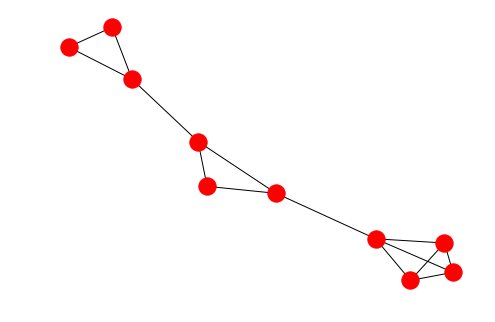

In [17]:
#PICTURE OF EXAMPLE
#Example: cluster 0-2, cluster of 3-5, cluster of 6-9, random initialization.
G=nx.Graph()
edges=[[1,2],[0,2],[0,1,3],\
       [2,4,5],[3,5],[3,4,6],\
       [5,7,8,9],[6,8,9],[6,7,9],[6,7,8]]
nodes=[i for i in range(10)]
G.add_nodes_from(nodes)
for i in range(10):
    toadd=edges[i]
    for j in range(len(toadd)):
        G.add_edge(i,toadd[j])
        
nx.draw(G)

And here is BigCLAM, using a random initialization for F.

In [40]:
# np.random.seed(2039)
F=np.random.rand(10,3)

comm_sums=F.sum(0) #sum over all communities, cached for updating in later version
eta=.1 #step size
for lezgo in range(1000): #number of iterations
    for i in nodes: #loop over rows of F
        F_grad=np.zeros(3) #initialize gradient
        comm_sums=F.sum(0) #should be cached, will deal with later since it's annoying to update correctly with the 0-check
        for j in edges[i]: #loop over nbrs of that row's node
                IP=np.exp(-np.inner(F[i], F[j])) #so we don't have to double compute
                F_grad+=F[j]*(1/(1-IP)) ##"first sum" above.
#                 print(i,j,F_grad)
        step=eta*(F_grad-comm_sums) #including F[i] here is the difference between you-are-own-neighbor and not
#         step=eta*(F_grad-comm_sums-F[i]) #correct option; above DIVERGES as steps->infty
        F[i]+=step #update row; doing as two steps so can use "step" to update comm_sums later
        F[i,F[i,:]<0]=0 #0-check
#         print('i',i,'step:', F_grad, 'baseline:',comm_sums) # sanity checks
print(F)

[[1.46103188 0.         0.        ]
 [1.46012614 0.         0.        ]
 [9.33371269 0.         0.        ]
 [0.76034951 1.48707302 0.        ]
 [0.         1.55666017 0.        ]
 [0.         9.35907419 0.        ]
 [0.         0.6952536  2.94591653]
 [0.         0.         2.94868911]
 [0.         0.         2.95277449]
 [0.         0.         2.94794287]]


Three things to try for your own use: 

1) Try this loop with a larger step size (Try `eta`=$\eta=.2$).  It may diverge.  This is a little scary!
    
2) Try this loop with the extra F(i) commented in *inside* the parenthesis of the `step=...` line.  This would match the slides.  It won't work!
    
3) When you use this in practice, you probably should adjust the `comm_sums` line if you want to not recompute that every step of the way.  Ideally you could just update with `comm_sums+= step` near the end... but this doesn't work if you end up changing the `comm_sums` by setting negative entries equal to zero.  It's only one line to fix, but think about it some!

NB: If we had included $[i,i]$ as an edge for every i, we should include the `-F[i])` inside the step parenthetical, and the algorithm seems to work, with our notation closer to that of the book.  See below:

In [37]:
edges=[[0,1,2],[0,1,2],[0,1,2,3],\
       [2,3,4,5],[3,4,5],[3,4,5,6],\
       [5,6,7,8,9],[6,7,8,9],[6,7,8,9],[6,7,8,9]]
nodes=[i for i in range(10)]

np.random.seed(2039)
F=np.random.rand(10,3)

comm_sums=F.sum(0) #sum over all communities, cached for updating in later version
nu=.1 #step size
for lezgo in range(3000): #number of iterations
    for i in nodes: #loop over rows of F
        F_grad=np.zeros(3) #initialize gradient
        comm_sums=F.sum(0) #should be cached, will deal with later since it's annoying to update correctly with the 0-check
        for j in edges[i]: #loop over nbrs of that row's node
                IP=np.exp(-np.inner(F[i], F[j])) #so we don't have to double compute
                F_grad+=F[j]*(IP/(1-IP)+1) ##"first sum" below.
                #print(F_grad)
        step=nu*(F_grad-comm_sums-F[i]) #
        F[i]+=step #update row; doing as two steps so can use "step" to update comm_sums later
        F[i,F[i,:]<0]=0 #0-check
        #print('i',i,'step:', F_grad, 'baseline:',comm_sums) # sanity checks
print(F)

[[0.         1.06892268 0.        ]
 [0.         1.06892268 0.        ]
 [0.         1.40198207 0.        ]
 [1.04821419 0.33585329 0.        ]
 [1.07200033 0.         0.        ]
 [1.40435033 0.         0.        ]
 [0.33071145 0.         1.25580956]
 [0.         0.         1.26950034]
 [0.         0.         1.26950034]
 [0.         0.         1.26950034]]


We should get almost the exact same values at convergence here as the variant using the "-F[u]" in the cells above.